In [ ]:
__author__ = 'Benjamin Weaver <benjamin.weaver@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20230613'
__datasets__ = ['desi_edr', 'ls_dr9']
__keywords__ = ['query', 'DESI']

# How to Query DESI EDR Data

## Table of Contents

* [Summary](#Summary)
* [Disclaimer and Attribution](#Disclaimer-and-Attribution)
* [Initial Setup](#Initial-Setup)
* [Contents of the Database](#Contents-of-the-Database)
* [Authentication](#Authentication)
* [Simple Queries](#Simple-Queries)
* [Joining Tables](#Joining-Tables)
* [Survey Progress](#Survey-Progress)
* [Using q3c](#Using-q3c)

## Summary

This notebook will cover the basics of using the DESI spectroscopic production database, `desi_edr`, which is loaded from the outputs of the DESI pipeline. This notebook is intended to cover as much of the detail of DESI's [introductory notebook tutorial](https://github.com/desihub/tutorials/blob/main/database/spectroscopic-production-database.ipynb) as possible, although rewritten for the Data Lab environment. For more details, including detailed table descriptions see DESI's [database access page](https://data.desi.lbl.gov/doc/access/database/).

## Disclaimer and Attribution

If you use this notebook for your published science, please acknowledge the following:

* DESI Data citation and acknowledgments: https://data.desi.lbl.gov/doc/acknowledgments/
* Data Lab concept paper: Fitzpatrick *et al.*, "The NOAO Data Laboratory: a conceptual overview", SPIE, **9149**, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.

In [1]:
#
# Imports
#
import csv
import os
from io import StringIO
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
import astropy.units as u
from dl import queryClient as qc, storeClient as sc, authClient as ac
#
# DESI software
#
from desitarget import __version__ as desitarget_version
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
#
# from astropy.time import Time
# from astropy.coordinates import ICRS
print(f"desitarget=={desitarget_version}")

desitarget==2.6.0


## Contents of the Database

### Schema

All tables are grouped into a database *schema* and that schema is named for the production run, (*e.g.* `fuji`).  When writing "raw" SQL, table names need to be schema-qualified, for example, `fuji.target`.  However, the SQLAlchemy abstraction layer is designed to take care of this for you.

### Important notes

* This database does not contain any sky spectra. Both deliberately-targeted (`targetid & 2**59 != 0`) and negative targetid (`targetid < 0`) sky spectra are excluded.
* Only quantities derived from *cumulative* tile-based spectra are included at the present time.

### The tables

* `photometry`. This contains the pure photometric data. Usually this is derived from the LS DR9 Tractor data, but not every *targeted* object has Tractor photometry.
  - Loaded from `tractorphot` files in the [lsdr9-photometry VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/lsdr9-photometry/): `/global/cfs/cdirs/desi/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/tractorphot/tractorphot-potential-*-fuji.fits`.
  - SQLAlchemy object: `db.Photometry`.
  - Primary key: `targetid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#photometry).
* `target`. This contains the targeting bits and other data generated by `desitarget`.
  - Loaded from `targetphot` file in the [lsdr9-photometry VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/lsdr9-photometry/): `/global/cfs/cdirs/desi/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/targetphot-potential-fuji.fits`.
  - SQLAlchemy object: `db.Target`.
  - Unique identifier: (`targetid`, `survey`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `tileid`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#target).
* `tile`. This contains information about observations grouped by tile.
  - Loaded from top-level `tiles-fuji.fits`.
  - SQLAlchemy object: `db.Tile`.
  - Primary key: `tileid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#tile).
* `exposure`. This contains information about individual exposures.
  - Loaded from top-level `exposures-fuji.fits`, `EXPOSURES` HDU.
  - SQLAlchemy object: `db.Exposure`.
  - Primary key: `expid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#exposure).
* `frame`. This contains information about individual exposures, but broken down by camera.  There will usually, but not always, be 30 frames per exposure.
  - Loaded from top-level `exposures-fuji.fits`, `FRAMES` HDU.
  - SQLAlchemy object: `db.Frame`.
  - Unique identifier: (`expid`, `camera`).
  - Primary key: `frameid`, composed from `expid` and a mapping of `camera` to an arbitrary integer.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#frame).
* `fiberassign`. This contains information about fiber positions.
  - Loaded from fiberassign files in the [tiles product](https://data.desi.lbl.gov/public/edr/target/fiberassign/tiles/tags/0.5/).  All fiberassign files corresponding to tiles in the `tile` table are loaded.
  - SQLAlchemy object: `db.Fiberassign`.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#fiberassign).
* `potential`. This contains a list of `targetid`s that *could* have been targeted on a given tile.
  - Loaded from the `POTENTIAL_ASSIGNMENTS` HDU in the same fiberassign files mentioned above.
  - SQLAlchemy object: `db.Potential`.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#potential).
* `zpix`. This contains the pipeline redshifts grouped by HEALPixel.
  - Loaded from the [zcat VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/zcat/): `/global/cfs/cdirs/desi/public/edr/vac/edr/zcat/fuji/v1.0/zall-pix-edr-vac.fits`.
  - Based on the `zall-pix-fuji.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Zpix`.
  - Unique identifier: (`targetid`, `survey`, `program`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `program`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#zpix).
* `ztile`. This contains the pipeline redshifts grouped by tile in a variety of ways.
  - Loaded from the [zcat VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/zcat/): `/global/cfs/cdirs/desi/public/edr/vac/edr/zcat/fuji/v1.0/zall-tilecumulative-edr-vac.fits`.
  - Based on the `zall-tilecumulative-fuji.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Ztile`.
  - Unique identifier: (`targetid`, `spgrp`, `spgrpval`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `spgrp`, `spgrpval`, `tileid`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#ztile).

### Foreign key relationships

* `fuji.target.targetid` -> `fuji.photometry.targetid`.
* `fuji.target.tileid` -> `fuji.tile.tileid`.
* `fuji.exposure.tileid` -> `fuji.tile.tileid`.
* `fuji.frame.expid` -> `fuji.exposure.expid`.
* `fuji.fiberassign.targetid` -> `fuji.photometry.targetid`.
* `fuji.fiberassign.tileid` -> `fuji.tile.tileid`.
* `fuji.potential.targetid` -> `fuji.photometry.targetid`.
* `fuji.potential.tileid` -> `fuji.tile.tileid`.
* `fuji.zpix.targetid` -> `fuji.photometry.targetid`.
* `fuji.ztile.targetphotid` -> `fuji.target.id`.
* `fuji.ztile.targetid` -> `fuji.photometry.targetid`.
* `fuji.ztile.tileid` -> `fuji.tile.tileid`.

## Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (*i.e.* you will need a registered user account).

If you need to log in to Data Lab, issue this command, and respond according to the instructions:

In [2]:
# ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'baweaver'

## Simple Queries

In most of the examples below, we include the equivalent raw SQL command that corresponds to the query.

### Exposures, Nights, Tiles

Here are some simple queries that demonstrate simple connections between nights, exposures and tiles.

#### How many tiles are there?

```SQL
SELECT COUNT(tileid) FROM desi_edr.tile;
```

In [3]:
response = qc.query(sql='SELECT COUNT(tileid) FROM desi_edr.tile;', fmt='csv', timeout=600)
print(response)

count
732



#### On which nights were a particular tile observed?

```SQL
SELECT night, expid FROM desi_edr.exposure WHERE tileid = 100;
```

In [4]:
response = qc.query(sql='SELECT night, expid FROM desi_edr.exposure WHERE tileid = 100;', fmt='csv', timeout=600)
print(response)

night,expid
20210504,87236
20210505,87361



#### Which tiles were observed on a night?

```SQL
SELECT tileid, survey, program FROM desi_edr.exposure WHERE night = 20210115;
```

In [5]:
response = qc.query(sql='SELECT tileid, survey, program FROM desi_edr.exposure WHERE night = 20210115;', fmt='csv', timeout=600)
print(response)

tileid,survey,program
80655,sv1,bright
80680,sv1,dark
80680,sv1,dark
80660,sv1,bright
80660,sv1,bright
80715,sv1,other
80715,sv1,other
80715,sv1,other
80674,sv1,dark
80674,sv1,dark
80674,sv1,dark
80683,sv1,dark
80683,sv1,dark
80678,sv1,dark
80678,sv1,dark
80688,sv1,dark
80688,sv1,dark
80685,sv1,dark
80685,sv1,dark
80662,sv1,bright
80662,sv1,bright
80663,sv1,bright
80663,sv1,bright
80690,sv1,dark
80690,sv1,dark
80653,sv1,bright
80653,sv1,bright
80700,sv1,dark
80700,sv1,dark
80699,sv1,dark
80699,sv1,dark
80665,sv1,bright
80665,sv1,bright
80707,sv1,dark
80707,sv1,dark



### Select ELG Targets

Note the special way we obtain the bitwise AND operator (`desi_mask.ELG == 2**1`).

```SQL
SELECT * from desi_edr.target WHERE (desi_target & 2) != 0;
```

In [6]:
response = qc.query(sql='SELECT * FROM desi_edr.target WHERE (desi_target & 2) != 0 LIMIT 10;', fmt='csv', timeout=600)
r = csv.DictReader(StringIO(response))
[(row['targetid'], row['desi_target'], row['survey'], row['program']) for row in r][:10]

id,subpriority,targetid,obsconditions,priority_init,numobs_init,hpxpixel,cmx_target,desi_target,bgs_target,mws_target,sv1_desi_target,sv1_bgs_target,sv1_mws_target,sv2_desi_target,sv2_bgs_target,sv2_mws_target,sv3_desi_target,sv3_bgs_target,sv3_mws_target,scnd_target,sv1_scnd_target,sv2_scnd_target,sv3_scnd_target,random_id,tileid,photsys,program,survey
158457821059512681299414356074,0.1144121160584064,39628267690397802,1,3200,2,27991,0,655458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.87824,81100,S,dark,special
158457821059512681299414355923,0.5282826315918009,39628267690397651,1,3100,2,27991,0,655394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.062133,81100,S,dark,special
158457821059512681305047305049,0.8304563334219317,39628273323346777,1,3200,2,27998,0,720931,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83.89114,81100,S,dark,special
158457821059512681305047305350,0.10535116018510304,39628273323347078,1,3100,2,27998,0,655394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.898089,81100,S,dark,special
158457821059512681299422744039,0.

#### Exercise

* How many objects in the `zpix` table have `spectype` 'GALAXY'?

### Redshift and Classification

Simple query filtering on string values. Note that the slice notation `[:20]` is equivalent to `LIMIT 20` in SQL.

```SQL
SELECT spectype, subtype, z FROM desi_edr.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;
```

In [9]:
response = qc.query(sql="SELECT spectype, subtype, z FROM desi_edr.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;", fmt='csv', timeout=600)
print(response)

spectype,subtype,z
STAR,K,2.5013987946123248e-05
STAR,K,-8.704151192323339e-05
STAR,K,-0.00040161483249588246
STAR,K,-9.348472543261597e-05
STAR,K,-0.0001868475708762835
STAR,G,-0.00013183419025712082
STAR,K,-7.360324170513955e-05
STAR,G,-0.00023738078942034326
STAR,G,-0.0001639114989381146
STAR,M,-6.719869580986891e-05
STAR,K,-0.00031095426246990194
STAR,F,0.00016654430310668832
STAR,WD,0.00022424183883441553
STAR,G,-4.629118225879226e-05
STAR,K,-0.00022123512005366112
STAR,F,-0.0005212801260396217
STAR,K,-7.243154947065121e-05
STAR,K,0.00024857887371239383
STAR,G,-0.0003726786931797866
STAR,M,-8.893736594737312e-05



## Joining Tables

### A Simple Join

Let's look at the nights and exposures on which a particular `TARGETID` was observed.

```SQL
SELECT f.tileid, e.expid, e.night FROM desi_edr.fiberassign AS f JOIN desi_edr.exposure AS e ON f.tileid = e.tileid WHERE f.targetid = 933811403620352;
```

In [10]:
q = """SELECT f.tileid, e.expid, e.night
FROM desi_edr.fiberassign AS f
JOIN desi_edr.exposure AS e ON f.tileid = e.tileid
WHERE f.targetid = 933811403620352;"""
response = qc.query(sql=q, fmt='csv', timeout=600)
print(response)

tileid,expid,night
278,85086,20210416
279,85209,20210417
279,85207,20210417
279,85206,20210417
279,85208,20210417
280,86981,20210502
280,86980,20210502



### Another Simple Join

In this case, we'll look at photometric flux and measured redshift. We'll `ORDER`(`BY`) the results and `LIMIT` the query with slice notation.

```SQL
SELECT p.*, z.* FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid ORDER BY z.z, p.flux_g LIMIT 50;
```

In [16]:
q = """SELECT p.*, z.*
FROM desi_edr.photometry AS p
JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
ORDER BY z.z, p.flux_g LIMIT 50;"""
response = qc.query(sql=q, fmt='csv', timeout=600)
r = csv.DictReader(StringIO(response))
flux_g, flux_r, flux_z, z = zip(*[(float(row['flux_g']), float(row['flux_r']), float(row['flux_z']), float(row['z'])) for row in r])

<ipython-input-18-8652ef935cf6>:4: RuntimeWarning: invalid value encountered in true_divide
  g_minus_r = np.log10(flux_r/flux_g)
<ipython-input-18-8652ef935cf6>:5: RuntimeWarning: invalid value encountered in true_divide
  r_minus_z = np.log10(flux_z/flux_r)


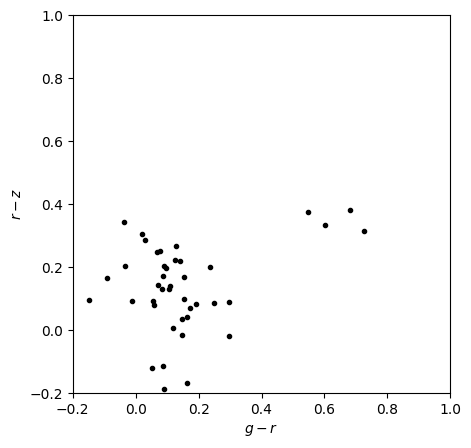

In [18]:
flux_g = np.array(flux_g)
flux_r = np.array(flux_r)
flux_z = np.array(flux_z)
g_minus_r = np.log10(flux_r/flux_g)
r_minus_z = np.log10(flux_z/flux_r)
redshift = np.array(z)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
p = axes.plot(g_minus_r, r_minus_z, 'k.')
foo = axes.set_xlim([-0.2, 1.0])
foo = axes.set_ylim([-0.2, 1.0])
foo = axes.set_aspect('equal')
foo = axes.set_xlabel('$g - r$')
foo = axes.set_ylabel('$r - z$')

#### Exercise

* Create a color-color plot for objects targeted as QSOs, and spectroscopically confirmed as such.

### A More Complicated Join

Let's look at objects that appear on more than one tile. For each of those tiles, how many exposures where there?

In this example, we're using `sqlalchemy.sql.func` to get the equivalent of `COUNT(*)` and a subquery that itself is a multi-table join.

```SQL
SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign FROM desi_edr.fiberassign AS f
    JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM desi_edr.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN desi_edr.tile AS t ON f.tileid = t.tileid LIMIT 100;
```

In [34]:
q = """SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign
FROM desi_edr.fiberassign AS f
JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM desi_edr.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
JOIN desi_edr.tile AS t ON f.tileid = t.tileid LIMIT 100;
"""
response = qc.query(sql=q, fmt='csv', timeout=600)
print(response) 

nexp,tileid,targetid,n_assign
7,80856,6432023904256,1
7,80856,6448025174016,1
2,80875,6515536691200,2
3,80876,6515536691200,2
4,80889,6521555517440,2
2,80890,6521555517440,2
8,80885,6536638234624,2
5,80886,6536638234624,2
8,80689,6546033475584,1
3,80715,28661214347265,1
3,80715,28665861636097,1
3,80715,28665861636098,1
3,80715,28665861636099,1
3,80715,28665865830400,1
3,80715,28665865830401,1
3,80715,28665874219008,1
3,80715,28665874219009,1
3,80715,28665878413313,1
3,80715,28670500536321,1
3,80715,28670504730624,1
3,80715,28670504730626,1
3,80715,28670508924930,1
3,80715,28670508924932,1
3,80715,28670508924934,1
3,80715,28670508924935,1
3,80715,28670508924936,1
3,80715,28670508924938,1
3,80715,28670508924940,1
3,80715,28670508924941,1
3,80715,28670513119233,1
3,80715,28670513119234,1
3,80715,28670521507841,1
3,80715,28670525702148,1
3,80715,28670529896451,1
3,80715,28675126853639,1
3,80715,28675131047936,1
3,80715,28675131047938,1
3,80715,28675131047940,1
3,80715,28675131047941,1
3,80

Now let's see what the redshift table thinks are the number of exposures for these objects.

```SQL
SELECT z.* FROM desi_edr.zpix AS z WHERE z.targetid IN (6432023904256, 6448025174016[, ...]);
```

In [38]:
q3 = """SELECT z.* FROM desi_edr.zpix AS z
WHERE z.targetid IN ({0});
""".format(', '.join([row['targetid'] for row in csv.DictReader(StringIO(response))]))
response3 = qc.query(sql=q3, fmt='csv', timeout=600)
r3 = csv.DictReader(StringIO(response3))
[(row['coadd_numexp'], row['zcat_nspec']) for row in r3]

[('0', '1'),
 ('7', '1'),
 ('5', '1'),
 ('5', '1'),
 ('3', '1'),
 ('8', '1'),
 ('3', '1'),
 ('3', '1'),
 ('3', '1')]

#### Exercise

* What is the distribution of number of exposures?

## Survey Progress

Let's see which nights have data, and count the number of exposures per night.

```SQL
SELECT e.night, COUNT(e.expid) AS n_exp FROM fuji.exposure AS e GROUP BY e.night ORDER BY e.night;
```

In [ ]:
q = db.dbSession.query(db.Exposure.night, func.count(db.Exposure.expid).label('n_exp')).group_by(db.Exposure.night).order_by(db.Exposure.night).all()
q

Observation timestamp for a given night.  Note how we have both MJD and a corresponding `datetime.datetime` object in the database.

```SQL
SELECT e.expid, e.mjd, e.date_obs FROM fuji.exposure AS e WHERE e.night = 20210428 ORDER BY e.expid;
```

In [ ]:
q = db.dbSession.query(db.Exposure.expid, db.Exposure.mjd, db.Exposure.date_obs).filter(db.Exposure.night == 20210428).order_by(db.Exposure.expid).all()
q

So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.  First, how many targets are there?

```SQL
SELECT COUNT(*) FROM fuji.target;
```

In [ ]:
N_targets = db.dbSession.query(db.Target).count()
N_targets

Now we look for targets that have observations and find the MJD of the observation.

```SQL
SELECT f.targetid, e.expid, e.mjd FROM fuji.fiberassign AS f
    JOIN (SELECT tt.targetid FROM fuji.target AS tt JOIN fuji.fiberassign AS ff ON tt.targetid = ff.targetid
              JOIN fuji.exposure AS ee ON ff.tileid = ee.tileid GROUP BY tt.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN fuji.exposure AS e ON f.tileid = e.tileid ORDER BY q1.targetid, e.expid;
```

In [ ]:
#
# Find all targetids that have observations.
#
q1 = db.dbSession.query(db.Target.targetid).filter(db.Target.targetid == db.Fiberassign.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).group_by(db.Target.targetid).subquery()
#
# Find the exposure times for the targetids that have been observed
#
q2 = db.dbSession.query(db.Fiberassign.targetid, db.Exposure.expid, db.Exposure.mjd).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).order_by(q1.c.targetid, db.Exposure.expid).all()
targetid, expid, mjd = zip(*q2)
targetid = np.array(targetid)
expid = np.array(expid)
mjd = np.array(mjd)
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

Now we have the targets and the date of last observation.  But it's sorted by `targetid`.

In [ ]:
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

In [ ]:
min_mjd = 10*(int(mjd.min())//10)
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(unique_mjd[ii][i3] - min_mjd, N_completed/N_targets, 'k-')
foo = axes.set_xlabel(f'MJD - {min_mjd:d}')
foo = axes.set_ylabel('Fraction completed')
foo = axes.grid(True)
# foo = axes.legend(loc=1)

### Exercise

* Break down the progress by target class, target bit, etc.

## Using q3c

[q3c](https://github.com/segasai/q3c) ([Koposov & Bartunov 2006](https://ui.adsabs.harvard.edu/abs/2006ASPC..351..735K/abstract)) is a popular library that provides spatial indexing and searching in astronomical databases. Here we'll demonstrate how to access this functionality. This is a radial ("cone") search on an arbitrary point in the DESI footprint:

```SQL
SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0); -- 1 arcmin
```

In [41]:
q = """SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0);"""
response = qc.query(sql=q, fmt='csv', timeout=600)
r = csv.DictReader(StringIO(response))
[(row['ra'], row['dec'], row['flux_g'], row['flux_r'], row['flux_z'], row['z'], row['zwarn'], row['spectype'], row['subtype']) for row in r]

[('179.99522053794',
  '-0.014802847289190747',
  '4.0703588',
  '3.8138902',
  '5.589977',
  '2.196265942356046',
  '0',
  'QSO',
  ''),
 ('179.99522053794',
  '-0.014802847289190747',
  '4.0703588',
  '3.8138902',
  '5.589977',
  '2.196330111093811',
  '0',
  'QSO',
  ''),
 ('179.99858271766036',
  '-0.01618414204249295',
  '15.193579',
  '34.151814',
  '63.77845',
  '0.10808701606173762',
  '0',
  'GALAXY',
  ''),
 ('179.98511167583362',
  '-0.004522219848854056',
  '18.790783',
  '54.5926',
  '101.71491',
  '0.0002480280785146229',
  '0',
  'STAR',
  'K'),
 ('179.98345446947602',
  '-0.0016128956796354296',
  '23.579397',
  '49.184425',
  '86.88554',
  '0.10876106194914885',
  '0',
  'GALAXY',
  ''),
 ('179.98454501706598',
  '-0.0010405313318174523',
  '180.03537',
  '308.1478',
  '258.64023',
  '-0.0019956912923479522',
  '1570',
  'STAR',
  'CV'),
 ('179.99827988329247',
  '-0.0021144339077160887',
  '2.1213698',
  '7.7856965',
  '15.824373',
  '0.24871746204685205',
  '0',
  'G

### Exercise

* What spectra are near your favourite object?